In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'mnist-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F102285%2F242592%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240308%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240308T180018Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D373e143b898ad27828b34bfd6f346e1528966ae2f01d36bc860f04423d85b9e4ac05cdc57fae00fe3d2e7073b6bf5b5e7c5de557bceda7cd47c86de5da5e0ace4ed8c886b7b3aa3c12988fee638f89db75fb454d17bf876698145bb950a23d6b953bb1eba60184176c768766bad62a78baa9c52d8137cc59b8e39add4c7b72fd10c45a708488acf19b648e3ad41a04d7d6520d6d050dc1bcae50328f17744741f4d50f1fe1cb8dc0aa9ca10fea14d4fec2fa4a465db9b76b97d29d1be840cd8ecdcdc42c2ffeb645f88f369680a11551cb5a622e4b65a00ce0657d476188e85ff4971a2236c33e0a238cbd62a8f27c2874218f9b3420cc8b63d62798cd915097,customclasses:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4464838%2F7795105%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240308%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240308T180018Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D06da6b93938f5b198d0a6e2054e8326f8dae57cdb66d5c37c8adbdf97b20c38ce0487989391b20f820c2fe594a49982050f945343f79343480d3295096e217924fbe44cc43297c3d8d7398bc1953baf50d9615f26a62dda8054689d8fb1198937cf6048e7131d54814e1572a4eb67fe24291bcde372f5ba1b61688c6044bee1ed7b7743b8a98a12a7b0d731894b2c6082e061ab0ff3bc24b6f0ad95508a33c6839929aeca9d81fca85f7ba8e1ace0d7e82d695b7731d445951535f29d6375ee57ecee3488ee8c120ee241fe76b83b34607e28688bc3a60d5425139031e8afe64d76bff241fb4b366d996ec815717e2ad497f36244d222bcde28af8a0bd8d9aac'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 23112702 bytes downloaded
Downloaded and uncompressed: mnist-dataset
[==================================================] 7759 bytes downloaded
Downloaded and uncompressed: customclasses
Data source import complete.


In [2]:
#import keras
#from keras import layers
import re, os, time

custom_dir = os.path.join('/kaggle/input', 'customclasses')
if custom_dir not in os.sys.path:
    os.sys.path.insert(0, custom_dir)

# Import all custom variables and modules
from preprocessing import *
from ae import *

RND_STATE = 247
keras.utils.set_random_seed(RND_STATE)

## Autoencoders
Following tutorial [Blog by F.Chollet](https://blog.keras.io/building-autoencoders-in-keras.html)

In [3]:
# Load MNIST digit dataset
#
input_path = '../input/mnist-dataset'
digits = MNIST_digits(input_path)

(x_train_, _), (x_test_, _) = digits.load_data()
img_shape = x_train_.shape[1:]

x_train = digits.normalize(x_train_, add_panel=False)
x_test = digits.normalize(x_test_, add_panel=False)
x_train = x_train.reshape((len(x_train), np.prod(img_shape)))
x_test = x_test.reshape((len(x_test), np.prod(img_shape)))


print("Dimension of training dataset: {:>15}".format(str(x_train.shape)))
print("Dimension of test dataset: {:>15}".format(str(x_test.shape)))

Dimension of training dataset:    (60000, 784)
Dimension of test dataset:    (10000, 784)


In [4]:
# Model configurations
conf = model_config()
conf.config('compile') #, metrics=[keras.metrics.F1Score(name='f1_score')])

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    #monitor="f1_score",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

conf.config(
    epochs=100,
    batch_size=256,
    shuffle=True,
    #validation_data=(x_test, x_test),
    validation_split=0.2,
    callbacks=[es_callback],
    verbose=0
)

### 1. Dense Autoencoders

In [5]:
model = AE_dense(latent_dim=32, img_shape=x_train.shape[1:], depth=3)
# model.encoder.summary()
# model.decoder.summary()
model.autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 encode_2 (Dense)            (None, 128)               100480    
                                                                 
 encode_1 (Dense)            (None, 64)                8256      
                                                                 
 encode_0 (Dense)            (None, 32)                2080      
                                                                 
 decode_0 (Dense)            (None, 32)                1056      
                                                                 
 decode_1 (Dense)            (None, 64)                2112      
                                                                 
 decode_2 (Dense)            (None, 128)               

In [6]:
model.autoencoder.compile(**conf.compile_args)


conf.config(x=x_train, y=x_train)

start = time.time()

history = model.autoencoder.fit(**conf.training_args)

print('training elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

Restoring model weights from the end of the best epoch: 95.
Epoch 100: early stopping
training elapsed time: ___ 1.59 minutes___


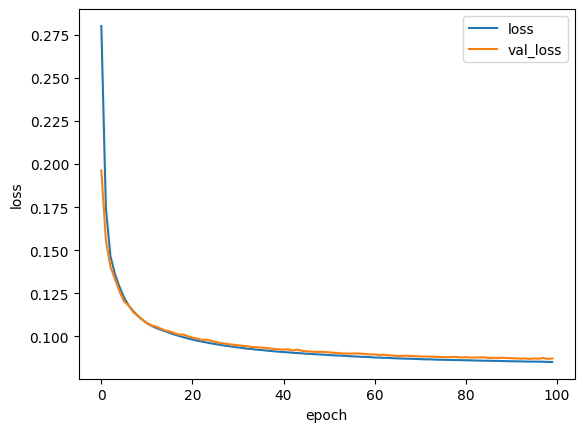

In [7]:
show_convergence(history, metrics=['loss','val_loss'])

In [8]:
decoded_imgs = model.predict(x_test)

model.evaluate_sklearn(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97   7385117
           1       0.55      0.90      0.68    454883

    accuracy                           0.95   7840000
   macro avg       0.77      0.93      0.83   7840000
weighted avg       0.97      0.95      0.96   7840000



{'Avg-precision': 0.67, 'f1-score-ODS': 0.68, 'f1-score-OIS': 0.68}

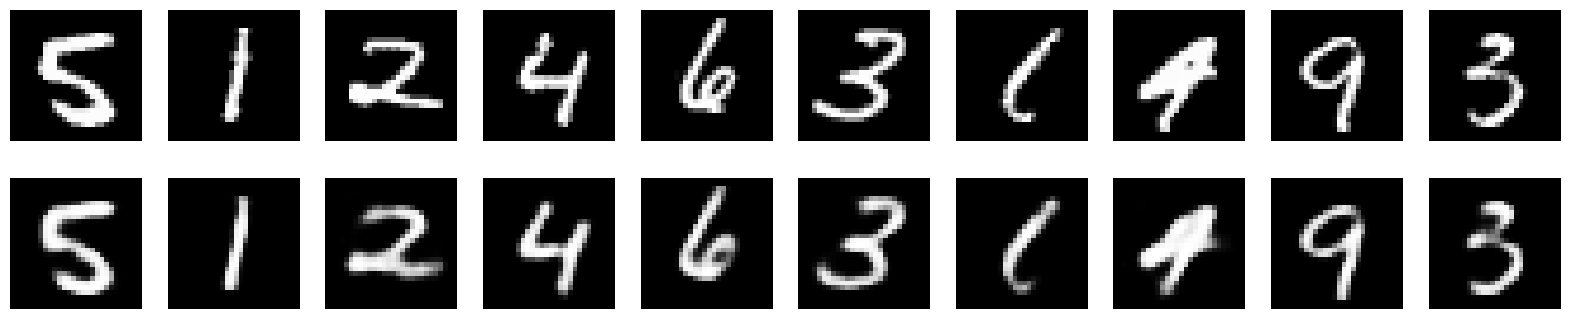

In [9]:
display_sample_images(x_test, decoded_imgs, img_shape)


### 2. ___Convolutional Autoencoders___

In [10]:
x_train = digits.normalize(x_train_)
x_test = digits.normalize(x_test_)

model2 = AE_convolutional(img_shape=x_train.shape[1:], panel_size=[16, 8, 8])
model2.autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 encode_2 (MaxPooling2D)     (None, 14, 14, 16)        0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 encode_1 (MaxPooling2D)     (None, 7, 7, 8)           0         
                                                                 
 Conv2DT_0 (Conv2D)          (None, 7, 7, 8)           584       
                                                                 
 decode_0 (UpSampling2D)     (None, 14, 14, 8)         

In [11]:
model2.autoencoder.compile(**conf.compile_args)

conf.config( x=x_train, y=x_train )

start = time.time()

history = model2.autoencoder.fit( **conf.training_args )

print('train time: {:5.2f}___minutes___'.format((time.time()-start) / 60))

train time:  2.40___minutes___


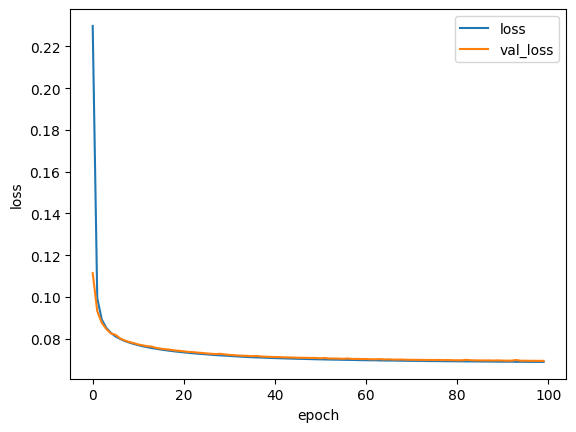

In [12]:
show_convergence(history, metrics=['loss','val_loss'])

In [13]:
decoded_imgs = model2.predict(x_test)

model2.evaluate_sklearn(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   7385117
           1       0.54      0.98      0.70    454883

    accuracy                           0.95   7840000
   macro avg       0.77      0.97      0.84   7840000
weighted avg       0.97      0.95      0.96   7840000



{'Avg-precision': 0.72, 'f1-score-ODS': 0.7, 'f1-score-OIS': 0.7}

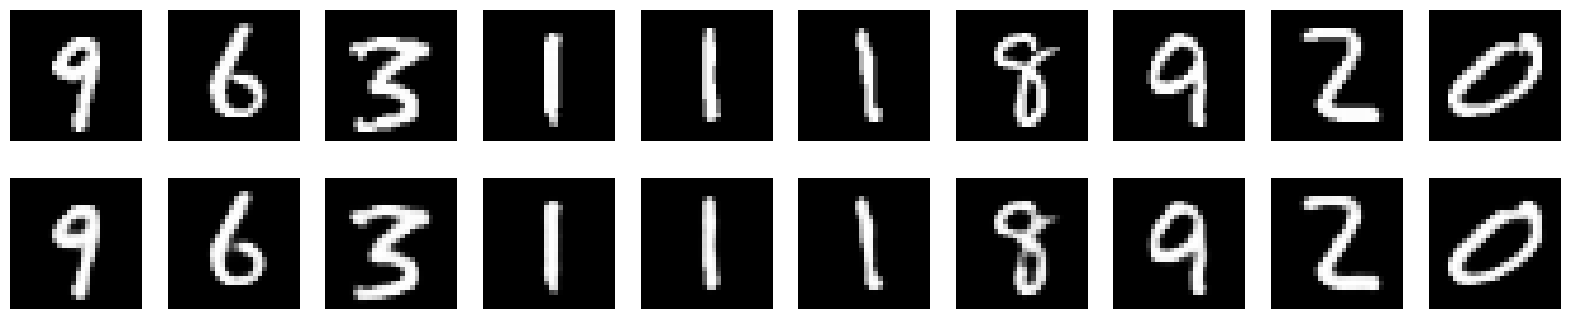

In [14]:
display_sample_images(x_test, decoded_imgs, img_shape)

#### Noise added

In [15]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [16]:
decoded_imgs = model2.predict(x_test_noisy)

model2.evaluate_sklearn(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97   7385117
           1       0.49      0.67      0.56    454883

    accuracy                           0.94   7840000
   macro avg       0.73      0.81      0.77   7840000
weighted avg       0.95      0.94      0.94   7840000



{'Avg-precision': 0.53, 'f1-score-ODS': 0.56, 'f1-score-OIS': 0.56}

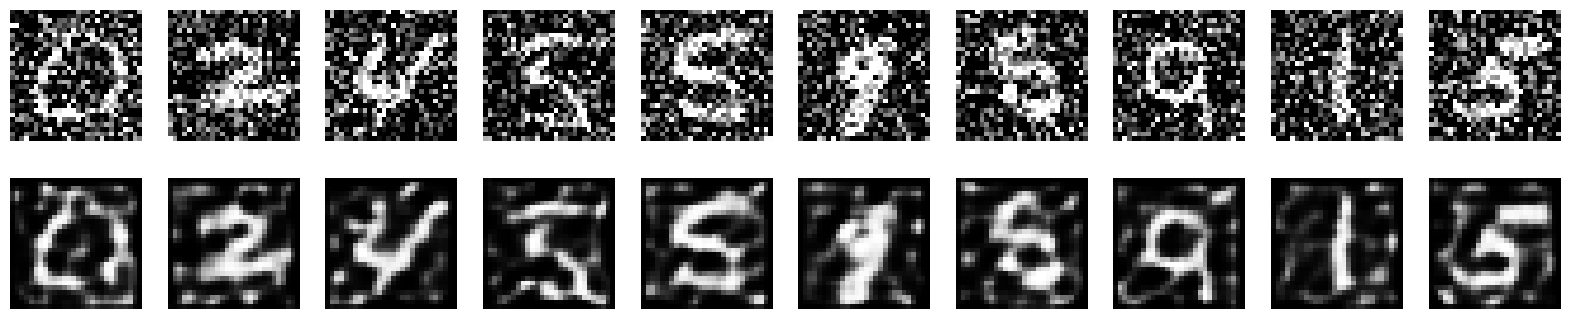

In [17]:
display_sample_images(x_test_noisy, decoded_imgs, img_shape)

#### Add more kernels to train on noisy data

In [18]:
model3 = AE_convolutional(img_shape=x_train.shape[1:], panel_size=[32,32])
model3.autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 encode_1 (MaxPooling2D)     (None, 14, 14, 32)        0         
                                                                 
 Conv2D_0 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 encode_0 (MaxPooling2D)     (None, 7, 7, 32)          0         
                                                                 
 Conv2DT_0 (Conv2D)          (None, 7, 7, 32)          9248      
                                                                 
 decode_0 (UpSampling2D)     (None, 14, 14, 32)        

In [19]:
model3.autoencoder.compile(**conf.compile_args)

conf.config( x=x_train_noisy, y=x_train )

start = time.time()

history = model3.autoencoder.fit( **conf.training_args )

print('train time: {:5.2f}___minutes___'.format((time.time()-start) / 60))
model3.training_args['epochs']

Restoring model weights from the end of the best epoch: 89.
Epoch 94: early stopping
train time:  2.82___minutes___


1

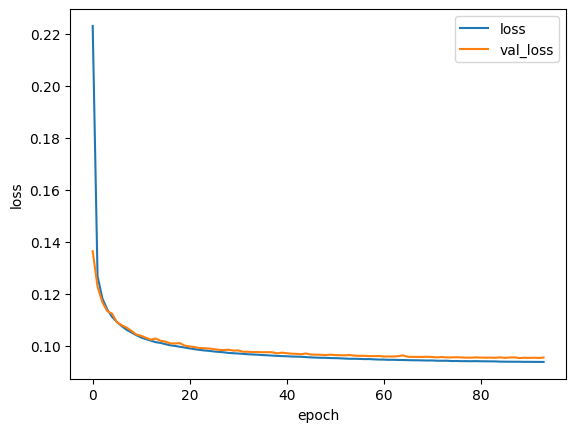

In [20]:
show_convergence(history, metrics=['loss','val_loss'])

In [21]:
decoded_imgs = model3.predict(x_test_noisy)

model3.evaluate_sklearn(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97   7385117
           1       0.54      0.88      0.67    454883

    accuracy                           0.95   7840000
   macro avg       0.77      0.92      0.82   7840000
weighted avg       0.97      0.95      0.95   7840000



{'Avg-precision': 0.65, 'f1-score-ODS': 0.67, 'f1-score-OIS': 0.67}

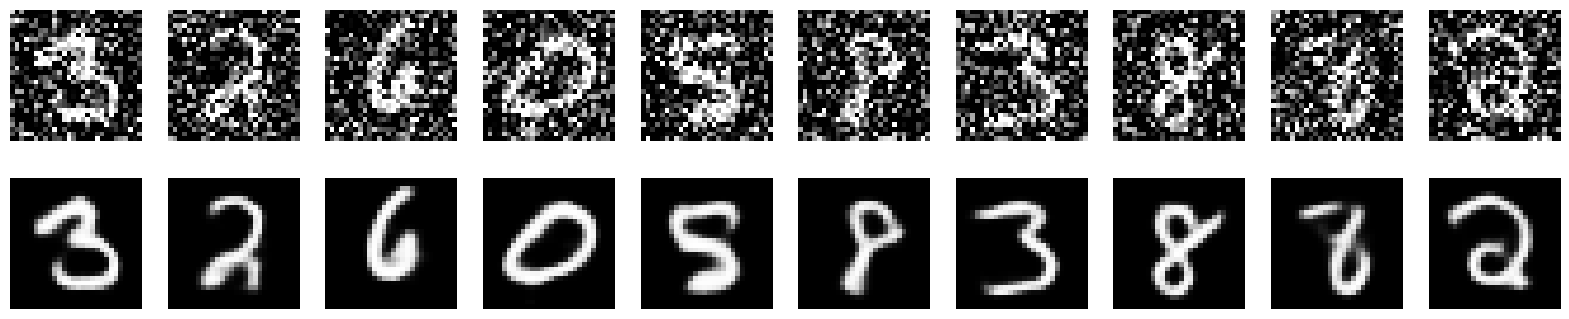

In [22]:
display_sample_images(x_test_noisy, decoded_imgs, img_shape)

### 3. Variational Autoencoders

In [23]:
model4 = AE_variational(img_shape=x_train.shape[1:], panel_size=[32,32], latent_dim=32)
model4.autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 Conv2D_1 (Conv2D)           (None, 28, 28, 32)           320       ['inputs[0][0]']              
                                                                                                  
 encode_1 (MaxPooling2D)     (None, 14, 14, 32)           0         ['Conv2D_1[0][0]']            
                                                                                                  
 Conv2D_0 (Conv2D)           (None, 14, 14, 32)           9248      ['encode_1[0][0]']            
                                                                                        

In [24]:
model4.compile(**conf.compile_args)

es_callback = keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True,
    mode='min'
)

conf.config( x=x_train_noisy, y=x_train, callbacks=[es_callback], verbose=1 )

start = time.time()

history = model4.fit( **conf.training_args )

print('train time: {:5.2f}___minutes___'.format((time.time()-start) / 60))

Epoch 1/100
188/188 [==============================] - 6s 15ms/step - loss: 288.6662 - reconstruction_loss: 232.2669 - kl_loss: 4.2576 - val_loss: 210.6078 - val_reconstruction_loss: 207.9395 - val_kl_loss: 2.6683
Epoch 2/100
188/188 [==============================] - 2s 10ms/step - loss: 209.0544 - reconstruction_loss: 202.5078 - kl_loss: 3.0458 - val_loss: 199.1133 - val_reconstruction_loss: 195.5195 - val_kl_loss: 3.5938
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 197.3295 - reconstruction_loss: 190.9048 - kl_loss: 4.5273 - val_loss: 190.8802 - val_reconstruction_loss: 185.1750 - val_kl_loss: 5.7053
Epoch 4/100
188/188 [==============================] - 2s 11ms/step - loss: 189.6936 - reconstruction_loss: 182.8965 - kl_loss: 5.6848 - val_loss: 185.7067 - val_reconstruction_loss: 179.8039 - val_kl_loss: 5.9029
Epoch 5/100
188/188 [==============================] - 2s 11ms/step - loss: 185.4393 - reconstruction_loss: 178.2860 - kl_loss: 5.9745 - val_los

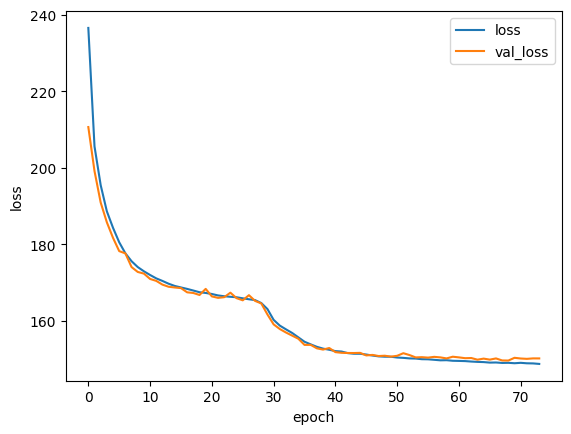

In [25]:
show_convergence(history, metrics=['loss','val_loss'])

In [26]:
decoded_imgs = model4.predict(x_test_noisy)

model4.evaluate_sklearn(x_test,decoded_imgs, threshold=0.8, report=True)

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.97   7385117
           1       0.45      0.40      0.42    454883

    accuracy                           0.94   7840000
   macro avg       0.71      0.69      0.69   7840000
weighted avg       0.93      0.94      0.93   7840000



{'Avg-precision': 0.43, 'f1-score-ODS': 0.31, 'f1-score-OIS': 0.42}

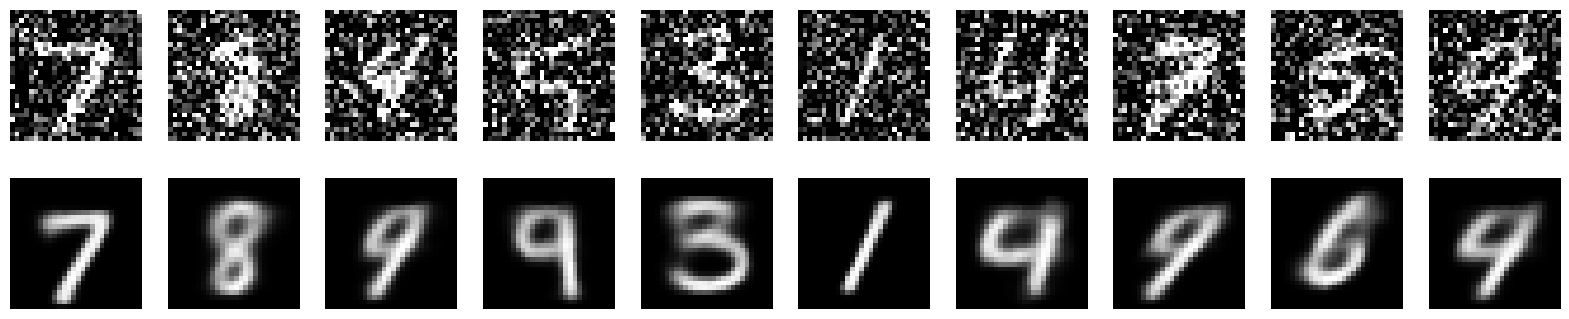

In [27]:
display_sample_images(x_test_noisy, decoded_imgs, img_shape)